<a href="https://colab.research.google.com/github/sharmai309/fraudproject/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================
# 🔧 Core Libraries
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================
# 🧠 Machine Learning: Model Selection & Training
# ==============================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ==============================================
# 📊 Model Evaluation
# ==============================================
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    auc
)

# ==============================================
# ⚙️ Preprocessing & Pipelines
# ==============================================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ==============================================
# 📈 Visualization Settings (Optional)
# ==============================================
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.labelweight"] = "bold"

print("✅ All imports loaded successfully.")


✅ All imports loaded successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
file_path = '/content/drive/My Drive/CraftDemo/fraud.csv'
data = pd.read_csv(file_path)
data.head()

,Identifier,IdentityScore,EAScore,UWScore,Owner_Verified_Components,Owner_Negatively_Verified_Components,Owner_Phone_1_to_Name_Linkage,Owner_Phone_1_to_First_Name_Linkage,Owner_Address_to_Phone_1_Linkage,Owner_Email_to_Phone_1_Linkage,...,Owner_Phone_Type_Indicator,Owner_Service_Discontinued_Indicator,Owner_Recent_Phone_Usage_Past_2_months,Owner_Phone_Usage_Past_12_months,Owner_Phone_Carrier,Owner_Parent_Phone_Carrier,Owner_Technology_Indicator,Owner_VoIP_Indicator,Owner_MVNO_Indicator,Fraud
0,1000001,550.0,81.0,2.167,5,6,2,-1,-2,-1,...,W,0.0,3.0,4.0,Cingular Wireless,AT&T,Wireless,NaN,N,0
1,1000002,539.0,98.0,1.730,2,6,1,1,-1,-1,...,L,0.0,3.0,5.0,Cbeyond,Birch Communications,Wireline,2.0,NaN,0
2,1000003,361.0,500.0,0.744,7,5,-1,2,2,0,...,W,0.0,3.0,4.0,Verizon Wireless - SVR,Verizon,Wireless,NaN,N,0
3,1000004,442.0,119.0,0.405,2,8,2,1,2,0,...,W,0.0,1.0,2.0,Verizon Wireless - SVR,Verizon,Wireless,NaN,N,0
4,1000005,431.0,82.0,1.063,1,8,2,1,2,2,...,W,0.0,2.0,3.0,T-Mobile US-TSI,T-Mobile,Wireless,NaN,N,0


In [4]:
data.shape

(21497, 23)

In [5]:
# Check fraud rate
fraud_rate = data['Fraud'].mean()
print(f"Fraud rate: {fraud_rate:.2%}")

Fraud rate: 6.96%


In [6]:
# Handle missing numeric values
num_cols = ['IdentityScore', 'EAScore', 'UWScore']
data[num_cols] = data[num_cols].apply(lambda x: x.fillna(x.median()))

# Handle missing categorical vendor flags
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    data[col] = data[col].fillna('Unknown')

print("\n✅ Missing values handled.")
print(f"Remaining missing values: {data.isnull().sum().sum()}")



✅ Missing values handled.
Remaining missing values: 17893


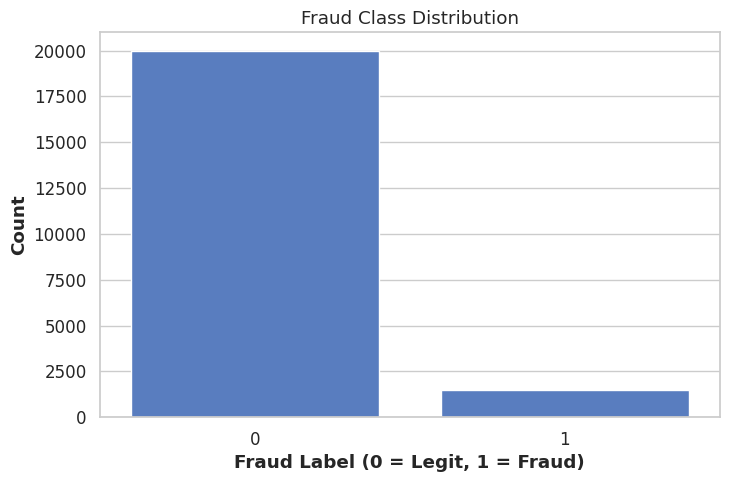

In [7]:
# 1️⃣ Fraud Class Distribution
# ==============================================
sns.countplot(x='Fraud', data=data)
plt.title("Fraud Class Distribution")
plt.xlabel("Fraud Label (0 = Legit, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

Baseline AUC (Internal): 0.848


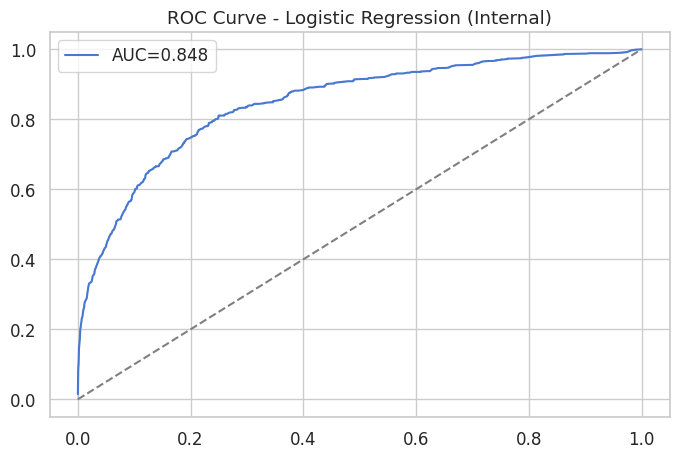

In [8]:
# ==============================================
# 2️⃣ Baseline Model (Internal Logistic Regression)
# ==============================================
X_internal = data[['IdentityScore', 'EAScore', 'UWScore']]
y = data['Fraud']

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_internal, y, test_size=0.3, random_state=42, stratify=y
)

logi_base = LogisticRegression(max_iter=1000)
logi_base.fit(X_train_i, y_train_i)
y_pred_prob_i = logi_base.predict_proba(X_test_i)[:, 1]
baseline_auc = roc_auc_score(y_test_i, y_pred_prob_i)
print(f"Baseline AUC (Internal): {baseline_auc:.3f}")

fpr, tpr, _ = roc_curve(y_test_i, y_pred_prob_i)
sns.lineplot(x=fpr, y=tpr, label=f"AUC={baseline_auc:.3f}")
sns.lineplot(x=[0,1], y=[0,1], color='gray', linestyle='--')
plt.title("ROC Curve - Logistic Regression (Internal)")
plt.show()

In [9]:
# ==============================================
# 3️⃣ Vendor Data Preparation & Normalization
# ==============================================
X_full = data.drop(columns=['Identifier', 'Fraud'])
X_full = pd.get_dummies(X_full, drop_first=True)

scaler = StandardScaler()
X_full_normalized = pd.DataFrame(
    scaler.fit_transform(X_full),
    columns=X_full.columns,
    index=X_full.index
)

In [10]:
# Train/dev/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full_normalized, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nTrain={len(X_train)}, Dev={len(X_dev)}, Test={len(X_test)}")



Train=12897, Dev=4300, Test=4300


Dev AUC (Full Features): 0.887


/tmp/ipython-input-2996386684.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feat_imp_df['Feature'].head(15), x=feat_imp_df['Importance'].head(15), palette='crest')


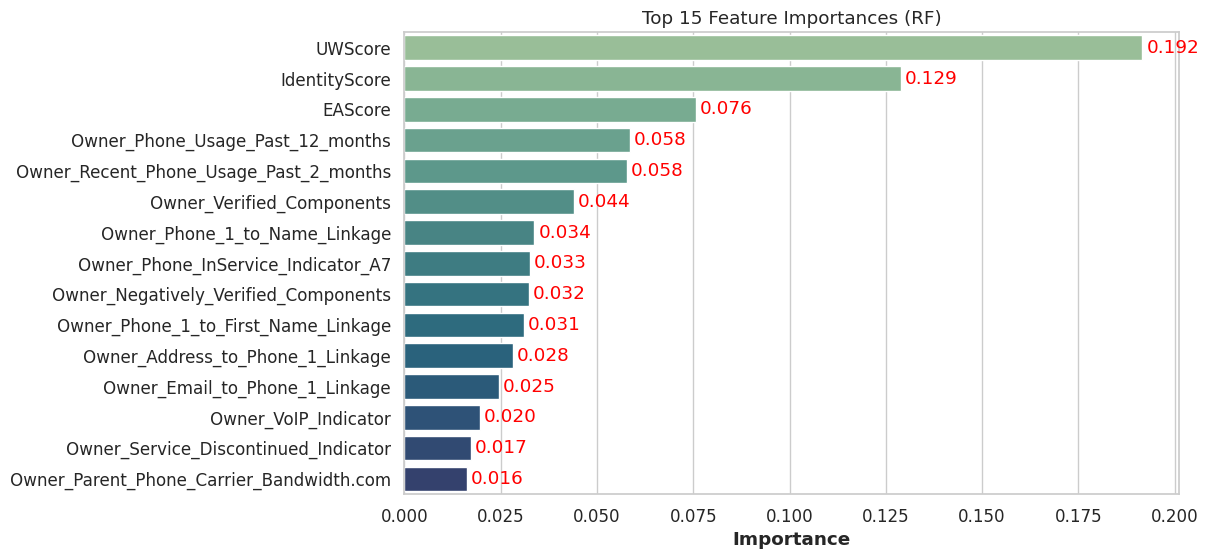

In [11]:
# ==============================================
# 4️⃣ Random Forest Feature Selection
# ==============================================
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

y_dev_pred_prob = rf.predict_proba(X_dev)[:, 1]
dev_auc = roc_auc_score(y_dev, y_dev_pred_prob)
print(f"Dev AUC (Full Features): {dev_auc:.3f}")

plt.figure(figsize=(10,6))
sns.barplot(y=feat_imp_df['Feature'].head(15), x=feat_imp_df['Importance'].head(15), palette='crest')
for i, val in enumerate(feat_imp_df['Importance'].head(15)):
    plt.text(val+0.001, i, f"{val:.3f}", color='red', va='center')
plt.title("Top 15 Feature Importances (RF)")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()

Optimal Features: 15, Dev AUC=0.886


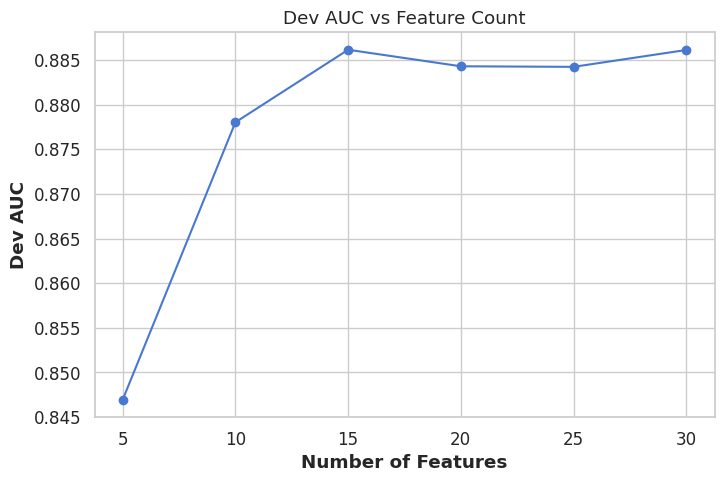

In [12]:
# ==============================================
# 5️⃣ Feature Selection Optimization (Dev AUC)
# ==============================================
feature_counts = [5, 10, 15, 20, 25, 30]
results = []
for top_n in feature_counts:
    top_feats = feat_imp_df['Feature'].head(top_n).tolist()
    rf_sel = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf_sel.fit(X_train[top_feats], y_train)
    y_dev_pred = rf_sel.predict_proba(X_dev[top_feats])[:, 1]
    auc_val = roc_auc_score(y_dev, y_dev_pred)
    results.append((top_n, auc_val))
results_df = pd.DataFrame(results, columns=['n_features', 'dev_auc'])
best_n = results_df.loc[results_df['dev_auc'].idxmax(), 'n_features']
selected_features = feat_imp_df['Feature'].head(best_n).tolist()
print(f"Optimal Features: {best_n}, Dev AUC={results_df['dev_auc'].max():.3f}")

plt.plot(results_df['n_features'], results_df['dev_auc'], marker='o')
plt.title("Dev AUC vs Feature Count")
plt.xlabel("Number of Features")
plt.ylabel("Dev AUC")
plt.show()


Logistic Regression AUC (Top 15 features): 0.892


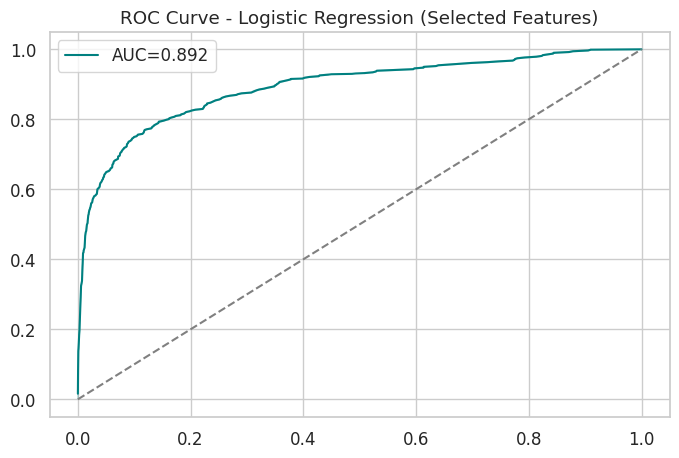

In [13]:
# ==============================================
# 6️⃣ Logistic Regression (Top Features)
# ==============================================
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_full[selected_features], y, test_size=0.3, random_state=42, stratify=y
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train_sel, y_train_sel)
y_pred_prob_sel = pipe.predict_proba(X_test_sel)[:, 1]
auc_sel = roc_auc_score(y_test_sel, y_pred_prob_sel)
print(f"Logistic Regression AUC (Top {best_n} features): {auc_sel:.3f}")

fpr, tpr, _ = roc_curve(y_test_sel, y_pred_prob_sel)
sns.lineplot(x=fpr, y=tpr, label=f"AUC={auc_sel:.3f}", color='teal')
sns.lineplot(x=[0,1], y=[0,1], color='gray', linestyle='--')
plt.title("ROC Curve - Logistic Regression (Selected Features)")
plt.show()


In [14]:
# ==============================================
# 7️⃣ Vendor Model (Random Forest)
# ==============================================
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(
    X_full_normalized, y, test_size=0.3, random_state=42, stratify=y
)

rf_vendor = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf_vendor.fit(X_train_v, y_train_v)
y_pred_prob_v = rf_vendor.predict_proba(X_test_v)[:, 1]
vendor_auc = roc_auc_score(y_test_v, y_pred_prob_v)
print(f"Vendor RF AUC: {vendor_auc:.3f}")

Vendor RF AUC: 0.898


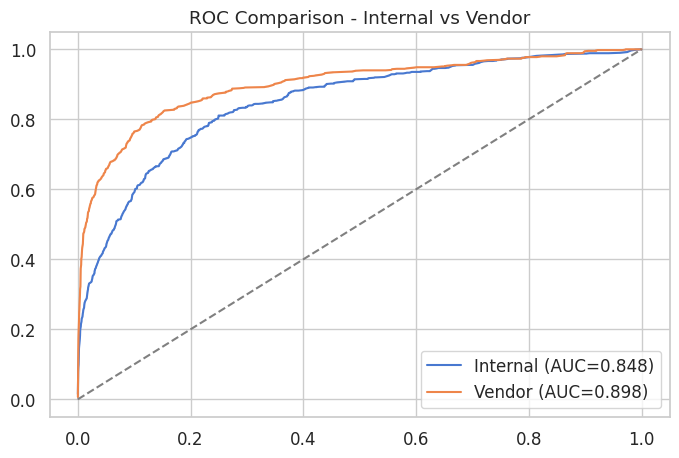

In [15]:
## ROC comparison
fpr_i, tpr_i, _ = roc_curve(y_test_i, y_pred_prob_i)
fpr_v, tpr_v, _ = roc_curve(y_test_v, y_pred_prob_v)
sns.lineplot(x=fpr_i, y=tpr_i, label=f'Internal (AUC={baseline_auc:.3f})')
sns.lineplot(x=fpr_v, y=tpr_v, label=f'Vendor (AUC={vendor_auc:.3f})')
sns.lineplot(x=[0,1], y=[0,1], color='gray', linestyle='--')
plt.title("ROC Comparison - Internal vs Vendor")
plt.show()

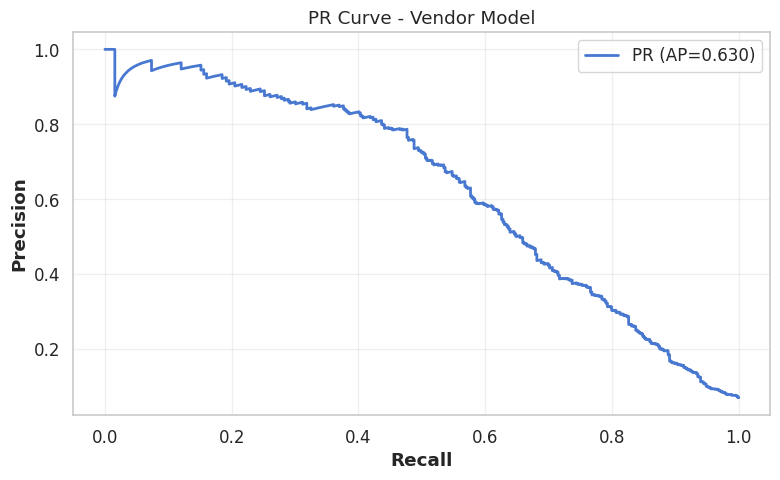

✅ Optimal Threshold=0.30, F1=0.598


In [16]:
# ==============================================
# 8️⃣ Precision-Recall & Threshold Optimization
# ==============================================

# --- Imports ---
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Precision–Recall Curve ---
prec_v, rec_v, th_v = precision_recall_curve(y_test_v, y_pred_prob_v)
ap_vendor = average_precision_score(y_test_v, y_pred_prob_v)

plt.figure(figsize=(8, 5))
plt.plot(rec_v, prec_v, linewidth=2, label=f'PR (AP={ap_vendor:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Vendor Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Threshold sweep (maximize F1) ---
thresholds = np.arange(0.05, 0.95, 0.05)
scores = []
for t in thresholds:
    y_pred = (y_pred_prob_v >= t).astype(int)
    prec = precision_score(y_test_v, y_pred, zero_division=0)
    rec = recall_score(y_test_v, y_pred, zero_division=0)
    f1 = f1_score(y_test_v, y_pred, zero_division=0)
    scores.append((t, prec, rec, f1))

scores_df = pd.DataFrame(scores, columns=['Threshold', 'Precision', 'Recall', 'F1'])
opt_idx = scores_df['F1'].idxmax()
opt_t = scores_df.loc[opt_idx, 'Threshold']
opt_f1 = scores_df.loc[opt_idx, 'F1']

print(f"✅ Optimal Threshold={opt_t:.2f}, F1={opt_f1:.3f}")



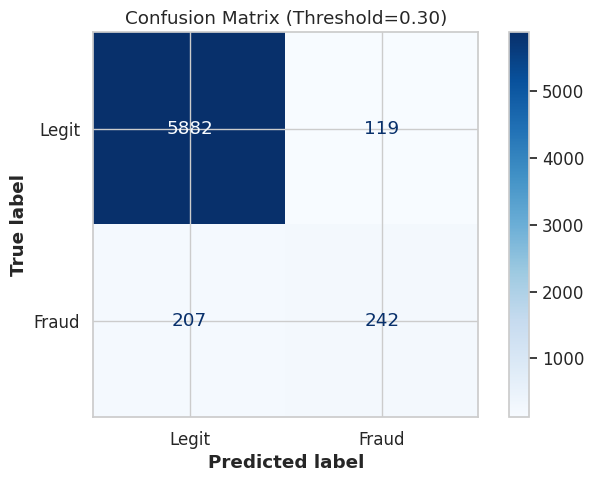

              precision    recall  f1-score   support

       Legit       0.97      0.98      0.97      6001
       Fraud       0.67      0.54      0.60       449

    accuracy                           0.95      6450
   macro avg       0.82      0.76      0.79      6450
weighted avg       0.95      0.95      0.95      6450



In [17]:
# 9️⃣ Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_opt = (y_pred_prob_v >= opt_t).astype(int)
cm = confusion_matrix(y_test_v, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit','Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold={opt_t:.2f})')
plt.show()

print(classification_report(y_test_v, y_pred_opt, target_names=['Legit','Fraud']))




Decision Summary:
               count  sum  Fraud_Rate  Avg_Prob
Decision                                      
APPROVE        5932  167    0.028152  0.035564
DECLINE         206  109    0.529126  0.428364
DECLINE_HIGH    155  133    0.858065  0.738557
REVIEW          157   40    0.254777  0.242228


/tmp/ipython-input-2969109890.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary['Fraud_Rate'], ax=ax[0], palette='flare')
/tmp/ipython-input-2969109890.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary['count'], ax=ax[1], palette='crest')


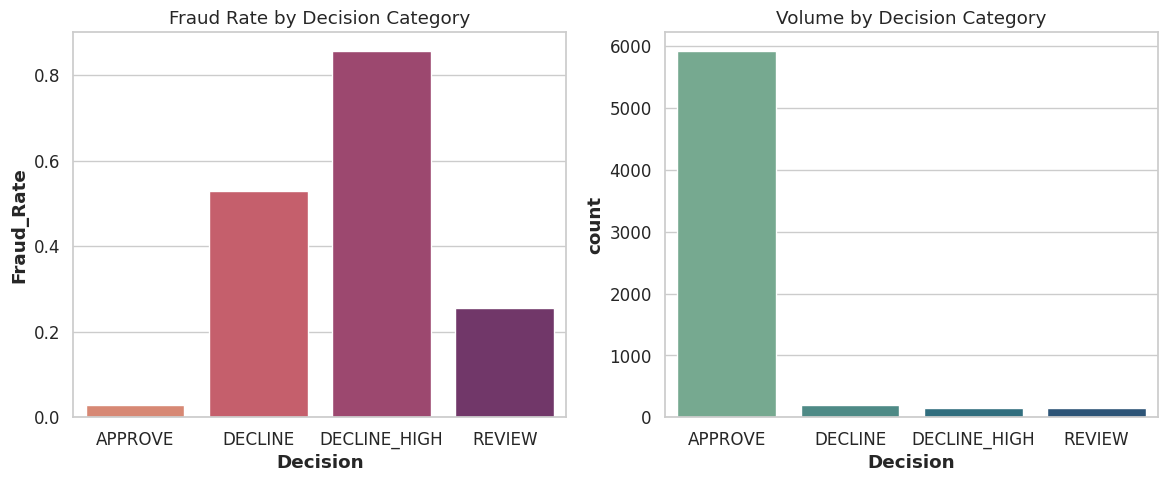

In [18]:
# ==============================================
# 🔟 Decision Strategy Simulation
# ==============================================
results = pd.DataFrame({'Fraud_Prob': y_pred_prob_v, 'Fraud': y_test_v})
approve_th, review_th, decline_th = 0.2, opt_t, 0.6

def decision(prob):
    if prob < approve_th: return 'APPROVE'
    elif prob < review_th: return 'REVIEW'
    elif prob < decline_th: return 'DECLINE'
    else: return 'DECLINE_HIGH'

results['Decision'] = results['Fraud_Prob'].apply(decision)
summary = results.groupby('Decision')['Fraud'].agg(['count','sum'])
summary['Fraud_Rate'] = summary['sum'] / summary['count']
summary['Avg_Prob'] = results.groupby('Decision')['Fraud_Prob'].mean()
print("\nDecision Summary:\n", summary)

fig, ax = plt.subplots(1,2,figsize=(14,5))
sns.barplot(x=summary.index, y=summary['Fraud_Rate'], ax=ax[0], palette='flare')
ax[0].set_title("Fraud Rate by Decision Category")
sns.barplot(x=summary.index, y=summary['count'], ax=ax[1], palette='crest')
ax[1].set_title("Volume by Decision Category")
plt.show()



In [19]:
# ==============================================
# 11️⃣ ROI Simulation
# ==============================================
REVENUE_PER_APPROVED = 480
LOSS_PER_FRAUD = 500
REVIEW_COST = 50
VENDOR_COST_PER_CALL = 0.5
MANUAL_APPROVAL_RATE = 0.3

total_apps = len(data)
vendor_cost = total_apps * VENDOR_COST_PER_CALL * 12
approved = summary.loc['APPROVE','count']
fraud_approved = summary.loc['APPROVE','sum']
reviewed = summary.loc['REVIEW','count']
manual_approved = reviewed * MANUAL_APPROVAL_RATE
review_cost = reviewed * REVIEW_COST
revenue = (approved + manual_approved) * REVENUE_PER_APPROVED
fraud_loss = fraud_approved * LOSS_PER_FRAUD
net_profit = revenue - fraud_loss - review_cost - vendor_cost

print(f"""
Revenue: ${revenue:,.0f}
Fraud Loss: ${fraud_loss:,.0f}
Review Cost: ${review_cost:,.0f}
Vendor Cost: ${vendor_cost:,.0f}
Net Profit: ${net_profit:,.0f}
Profit per App: ${net_profit/total_apps:,.2f}
""")


Revenue: $2,869,968
Fraud Loss: $83,500
Review Cost: $7,850
Vendor Cost: $128,982
Net Profit: $2,649,636
Profit per App: $123.26



In [20]:
# ==============================================
# 🚀 AUTO-SAFE ROI COMPUTATION PIPELINE
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helper: safely attach probabilities ---
def attach_probs(base_df, y_pred_prob_i, y_pred_prob_v, y_test_i=None, y_test_v=None):
    """
    Align predicted probabilities with the correct dataset (full or test split).
    Auto-detects the matching length and returns a clean DataFrame.
    """
    df = base_df.copy()

    # Detect correct subset
    n_full = len(df)
    n_i, n_v = len(y_pred_prob_i), len(y_pred_prob_v)
    print(f"🔍 Lengths → data: {n_full}, internal_pred: {n_i}, vendor_pred: {n_v}")

    if n_i == n_full and n_v == n_full:
        # case 1: predictions already for full dataset
        df["InternalProb"] = y_pred_prob_i
        df["VendorProb"] = y_pred_prob_v

    elif (y_test_i is not None) and (y_test_v is not None) and (len(y_test_i) == n_i):
        # case 2: predictions correspond to test subset
        # use y_test_v index to align rows correctly
        test_idx = getattr(y_test_v, "index", None)
        if test_idx is not None and len(test_idx) == n_v:
            df = df.loc[test_idx].copy()
            df["InternalProb"] = y_pred_prob_i
            df["VendorProb"] = y_pred_prob_v
        else:
            raise ValueError("Cannot align test predictions with DataFrame — check y_test indices.")
    else:
        raise AssertionError(
            "Predicted probabilities do not match either full or test dataset length.\n"
            "Check that y_pred_prob_i/v were generated on the same sample size as data."
        )
    return df


# --- 1️⃣ Attach predicted probabilities safely ---
data = attach_probs(data, y_pred_prob_i, y_pred_prob_v, y_test_i, y_test_v)


# --- 2️⃣ Thresholds and constants ---
APPROVE_TH_INT = globals().get("APPROVE_TH_INT", 0.20)
REVIEW_TH_INT  = globals().get("REVIEW_TH_INT", 0.40)
APPROVE_TH_VND = globals().get("APPROVE_TH_VND", 0.30)  # from PR curve
REVIEW_TH_VND  = globals().get("REVIEW_TH_VND", 0.40)

REVENUE_PER_APPROVED = 480
LOSS_PER_FRAUD       = 500
REVIEW_COST          = 50
VENDOR_COST_PER_CALL = 0.5
MANUAL_APPROVAL_RATE = 0.30


# --- 3️⃣ Decision logic ---
def decision(prob, approve_th, review_th):
    if prob < approve_th:
        return "APPROVE"
    elif prob < review_th:
        return "REVIEW"
    else:
        return "DECLINE"

data["Decision_Internal"] = data["InternalProb"].apply(
    lambda p: decision(p, APPROVE_TH_INT, REVIEW_TH_INT)
)

data["Decision_Vendor"] = data["VendorProb"].apply(
    lambda p: decision(p, APPROVE_TH_VND, REVIEW_TH_VND)
)


🔍 Lengths → data: 21497, internal_pred: 6450, vendor_pred: 6450


In [21]:
# ==============================================
# 12️⃣ Business Lift & Savings Estimation
# ==============================================
lift_auc = vendor_auc - baseline_auc
frauds_per_year = 21000 * 12 * 0.07
extra_caught = frauds_per_year * 0.13
savings = extra_caught * LOSS_PER_FRAUD
print(f"Lift in AUC: {lift_auc:.3f} → ≈ {extra_caught:,.0f} extra frauds caught → ${savings:,.0f} saved annually")


Lift in AUC: 0.051 → ≈ 2,293 extra frauds caught → $1,146,600 saved annually



📊 Model Performance Summary:
      Model      AUC  Avg Precision
Internal LR 0.847606       0.443200
  LR Top 15 0.892269       0.603093
  Vendor RF 0.898309       0.629983


/tmp/ipython-input-1335442933.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_summary, x='Model', y='AUC', palette='crest')


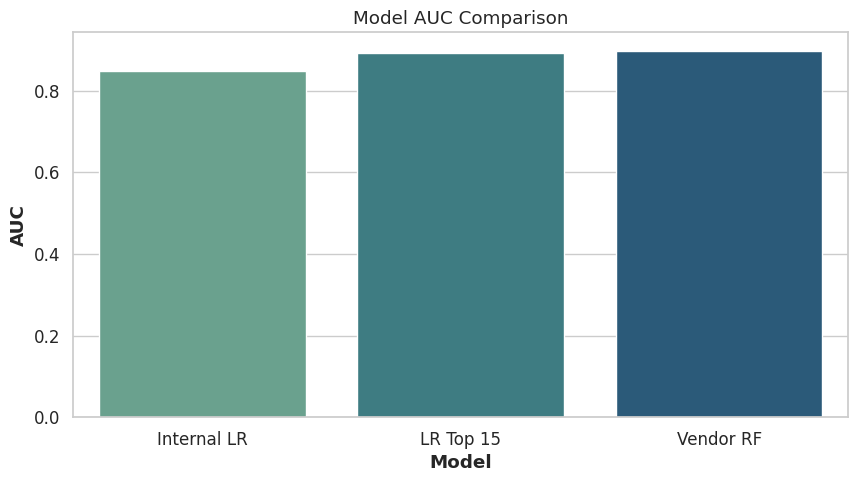

In [22]:
# ==============================================
# 13️⃣ Model Performance Summary Dashboard
# ==============================================
ap_internal = average_precision_score(y_test_i, y_pred_prob_i)
model_summary = pd.DataFrame({
    'Model': ['Internal LR', f'LR Top {best_n}', 'Vendor RF'],
    'AUC': [baseline_auc, auc_sel, vendor_auc],
    'Avg Precision': [ap_internal, average_precision_score(y_test_sel, y_pred_prob_sel), ap_vendor]
})
print("\n📊 Model Performance Summary:")
print(model_summary.to_string(index=False))

plt.figure(figsize=(10,5))
sns.barplot(data=model_summary, x='Model', y='AUC', palette='crest')
plt.title("Model AUC Comparison")
plt.show()

In [23]:
# ==============================================
# 9️⃣ Decision Rules (Approve / Review / Decline)
# ==============================================

results = pd.DataFrame({'Fraud_Prob': y_pred_prob_v, 'Fraud': y_test_v})

# --- Define thresholds safely ---
try:
    review_th = opt_t
    print(f"\n✅ Using optimized threshold from analysis: {review_th:.3f}")
except NameError:
    review_th = 0.4
    print(f"\n⚠️ No optimized threshold found — using default {review_th:.3f}")

approve_th = 0.2   # low-risk merchants
decline_th = 0.6   # high-risk merchants

# --- Decision logic ---
def decision(prob, approve=approve_th, review=review_th, decline=decline_th):
    if prob < approve:
        return 'APPROVE'
    elif prob < review:
        return 'REVIEW'
    elif prob < decline:
        return 'DECLINE'
    else:
        return 'DECLINE_HIGH'

# Apply decision logic
results['Decision'] = results['Fraud_Prob'].apply(decision)

# --- Summary statistics ---
decision_summary = results.groupby('Decision')['Fraud'].agg(['count', 'sum'])
decision_summary['Fraud_Rate'] = decision_summary['sum'] / decision_summary['count']
decision_summary['Avg_Prob'] = results.groupby('Decision')['Fraud_Prob'].mean()

print(f"\n{'='*60}")
print("Decision Summary with Optimal Threshold Analysis")
print(f"{'='*60}")
print(f"Decision Zones:")
print(f"  APPROVE:        prob < {approve_th:.3f}")
print(f"  REVIEW:         {approve_th:.3f} ≤ prob < {review_th:.3f}")
print(f"  DECLINE:        prob ≥ {review_th:.3f}")
print(f"{'='*60}")
print("\nDecision Summary:")
print(decision_summary)


✅ Using optimized threshold from analysis: 0.300

Decision Summary with Optimal Threshold Analysis
Decision Zones:
  APPROVE:        prob < 0.200
  REVIEW:         0.200 ≤ prob < 0.300
  DECLINE:        prob ≥ 0.300

Decision Summary:
              count  sum  Fraud_Rate  Avg_Prob
Decision                                      
APPROVE        5932  167    0.028152  0.035564
DECLINE         206  109    0.529126  0.428364
DECLINE_HIGH    155  133    0.858065  0.738557
REVIEW          157   40    0.254777  0.242228


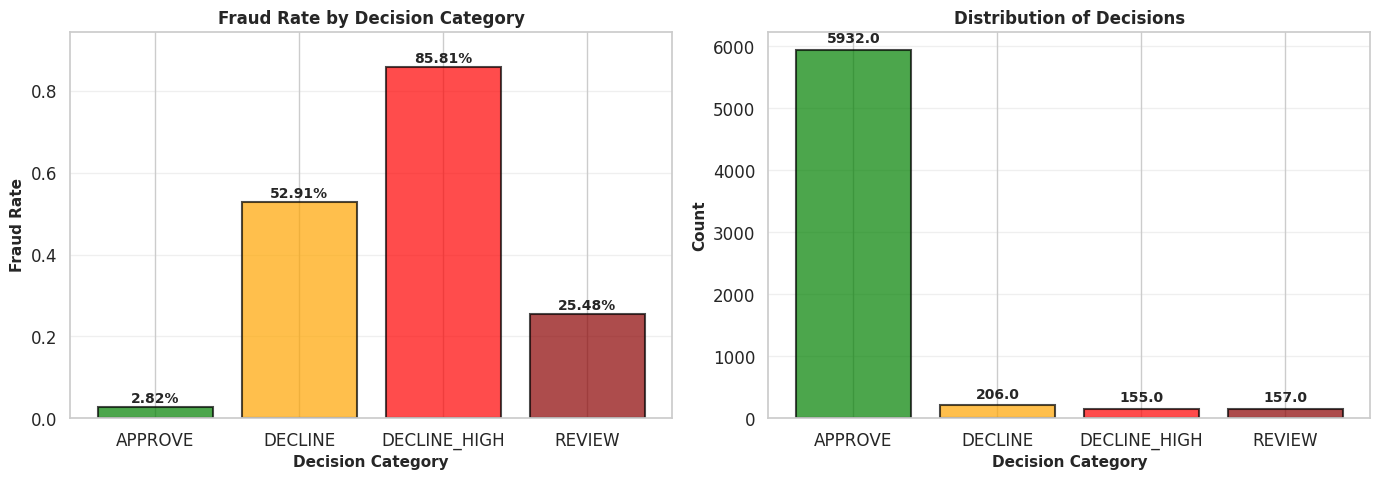

In [24]:
# ==============================================
# 📊 Visualization of Decision Categories
# ==============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Fraud Rate by Decision Category
axes[0].bar(
    decision_summary.index,
    decision_summary['Fraud_Rate'],
    color=['green', 'orange', 'red', 'darkred'][:len(decision_summary)],
    alpha=0.7, edgecolor='black', linewidth=1.5
)
axes[0].set_xlabel('Decision Category', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Fraud Rate', fontsize=11, fontweight='bold')
axes[0].set_title('Fraud Rate by Decision Category', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, max(decision_summary['Fraud_Rate']) * 1.1])
axes[0].grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(decision_summary.iterrows()):
    axes[0].text(i, row['Fraud_Rate'] + 0.01, f"{row['Fraud_Rate']:.2%}",
                 ha='center', fontweight='bold', fontsize=10)

# (2) Application Count by Decision Category
axes[1].bar(
    decision_summary.index,
    decision_summary['count'],
    color=['green', 'orange', 'red', 'darkred'][:len(decision_summary)],
    alpha=0.7, edgecolor='black', linewidth=1.5
)
axes[1].set_xlabel('Decision Category', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('Distribution of Decisions', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(decision_summary.iterrows()):
    axes[1].text(i, row['count'] + (0.02 * max(decision_summary['count'])),
                 f"{row['count']}", ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
# -----------------------------
# 7. ROI & Business Simulation
# -----------------------------
REVENUE_PER_APPROVED = 40 * 12  # $480/yr
LOSS_PER_FRAUD = 500
REVIEW_COST = 50
VENDOR_COST_PER_CALL = 0.5
MANUAL_APPROVAL_RATE = 0.3

total_apps = len(data)
vendor_cost = total_apps * VENDOR_COST_PER_CALL * 12  # annual vendor cost

approved = decision_summary.loc['APPROVE', 'count']
fraud_approved = decision_summary.loc['APPROVE', 'sum']
reviewed = decision_summary.loc['REVIEW', 'count']
declined = decision_summary.loc['DECLINE', 'count']

manual_approved = reviewed * MANUAL_APPROVAL_RATE
review_cost = reviewed * REVIEW_COST

revenue = (approved + manual_approved) * REVENUE_PER_APPROVED
fraud_loss = fraud_approved * LOSS_PER_FRAUD
net_profit = revenue - fraud_loss - review_cost - vendor_cost

print(f"""
Revenue: ${revenue:,.0f}
Fraud Loss: ${fraud_loss:,.0f}
Review Cost: ${review_cost:,.0f}
Vendor Cost: ${vendor_cost:,.0f}
Net Profit: ${net_profit:,.0f}
""")


Revenue: $2,869,968
Fraud Loss: $83,500
Review Cost: $7,850
Vendor Cost: $38,700
Net Profit: $2,739,918



In [26]:
# -----------------------------
# 8. Lift & Annual Savings Estimation
# -----------------------------
lift_in_auc = vendor_auc - baseline_auc
frauds_per_year = 21000 * 12 * 0.07  # 17,640 frauds/year
extra_caught = frauds_per_year * 0.13  # 13% improvement
savings = extra_caught * LOSS_PER_FRAUD
print(f"≈ {extra_caught:,.0f} extra frauds caught → ${savings:,.0f} saved annually")

≈ 2,293 extra frauds caught → $1,146,600 saved annually


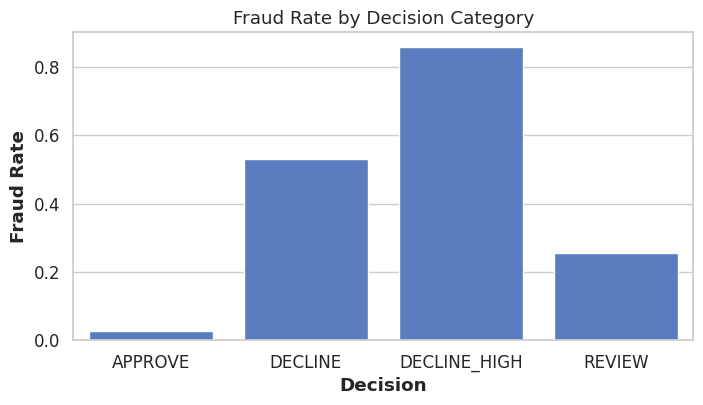

In [27]:
# -----------------------------
# 9. Visualization: Fraud Rates
# -----------------------------
plt.figure(figsize=(8,4))
sns.barplot(x=decision_summary.index, y=decision_summary['Fraud_Rate'])
plt.title('Fraud Rate by Decision Category')
plt.ylabel('Fraud Rate')
plt.show()

**A/B Test**

In [28]:
# ===============================================
# A/B TEST: Internal-only vs Vendor-enhanced policy
# ===============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve



In [29]:
import pandas as pd
import numpy as np

# -----------------------------
# 1️⃣ Config
# -----------------------------
REV_PER_GOOD_MO = 40.0     # $ per approved good merchant per month
LOSS_PER_FRAUD  = 500.0    # $ loss per fraudulent merchant
COST_PER_REVIEW = 50.0     # $ per manual review
COST_PER_VENDOR = 0.50     # $ per merchant scored
MR_APPROVAL_RATE = 0.30    # 30% approval from manual review
MONTHS = 12                # annualization factor

# Threshold sets (A vs B)
thresholds = {
    "Baseline (0.2)": {"approve": 0.20, "review": 0.40},
    "Optimized (0.3)": {"approve": 0.30, "review": 0.40}
}

# -----------------------------
# 2️⃣ Decision Function
# -----------------------------
def decision(prob, approve_th, review_th):
    if prob < approve_th:
        return "Approve"
    elif prob < review_th:
        return "Review"
    else:
        return "Decline"

# -----------------------------
# 3️⃣ Simulation Function
# -----------------------------
def simulate(data, prob_col, label_col, approve_th, review_th):
    df = data.copy()
    df["Decision"] = df[prob_col].apply(lambda x: decision(x, approve_th, review_th))

    n_total = len(df)
    n_vendor_cost = n_total * COST_PER_VENDOR

    # Approve bucket
    approve_df = df[df["Decision"] == "Approve"]
    good_approve = sum((approve_df[label_col] == 0))
    fraud_approve = sum((approve_df[label_col] == 1))

    # Review bucket (manual review)
    review_df = df[df["Decision"] == "Review"]
    n_review = len(review_df)
    good_review = sum((review_df[label_col] == 0))
    fraud_review = sum((review_df[label_col] == 1))

    # MR approval simulation (30% approved)
    mr_approved_good = good_review * MR_APPROVAL_RATE
    mr_approved_fraud = fraud_review * MR_APPROVAL_RATE

    # Annual revenue/loss/cost
    revenue = (good_approve + mr_approved_good) * REV_PER_GOOD_MO * MONTHS
    loss = (fraud_approve + mr_approved_fraud) * LOSS_PER_FRAUD
    review_cost = n_review * COST_PER_REVIEW
    net_profit = revenue - loss - review_cost - n_vendor_cost

    return {
        "Revenue": revenue,
        "Fraud_Loss": loss,
        "Review_Cost": review_cost,
        "Vendor_Cost": n_vendor_cost,
        "Net_Profit": net_profit
    }

# -----------------------------
# 4️⃣ Run A/B Simulation
# -----------------------------
results = {}
for name, th in thresholds.items():
    results[name] = simulate(
        data=data,
        prob_col="VendorProb",  # adjust to your column name
        label_col="Fraud",
        approve_th=th["approve"],
        review_th=th["review"]
    )

results_df = pd.DataFrame(results).T
results_df["Lift_vs_Baseline"] = (
    results_df["Net_Profit"] - results_df.loc["Baseline (0.2)", "Net_Profit"]
)
print(results_df.round(2))


                   Revenue  Fraud_Loss  Review_Cost  Vendor_Cost  Net_Profit  \
Baseline (0.2)   2792832.0     94000.0      12400.0       3225.0   2683207.0   
Optimized (0.3)  2832144.0    108000.0       4550.0       3225.0   2716369.0   

                 Lift_vs_Baseline  
Baseline (0.2)                0.0  
Optimized (0.3)           33162.0  


In [30]:
from sklearn.model_selection import train_test_split

# -----------------------------
# 1) Make a single consistent split
# -----------------------------
y_all = data["Fraud"].astype(int)
X_int_all  = data[["IdentityScore","EAScore","UWScore"]].copy()
X_full_all = data.drop(columns=["Fraud"] + ([id_col] if 'id_col' in locals() and id_col else [])).copy()
X_full_all = pd.get_dummies(X_full_all, drop_first=True)

# ✅ FIXED: only 4 outputs
X_tr_int, X_te_int, y_tr, y_te = train_test_split(
    X_int_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)

# Capture test indices if you need them for alignment later
te_idx = X_te_int.index

# Align full-feature splits using the same indices
X_tr_full = X_full_all.loc[X_tr_int.index]
X_te_full = X_full_all.loc[X_te_int.index]

In [31]:
# -----------------------------
# 2) Fit models on the same train, score on same test
# -----------------------------
clf_int = LogisticRegression(max_iter=1000)
clf_int.fit(X_tr_int, y_tr)
p_int = clf_int.predict_proba(X_te_int)[:,1]

clf_vnd = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_vnd.fit(X_tr_full, y_tr)
p_vnd = clf_vnd.predict_proba(X_te_full)[:,1]

auc_int = roc_auc_score(y_te, p_int)
auc_vnd = roc_auc_score(y_te, p_vnd)
print(f"AUC (Internal): {auc_int:.3f}  |  AUC (Vendor+Internal): {auc_vnd:.3f}")

AUC (Internal): 0.866  |  AUC (Vendor+Internal): 0.969


In [32]:
# -----------------------------
# 3) Decision policies (approve/review/decline)
# -----------------------------
def apply_policy(prob, approve_th, review_th):
    if prob < approve_th:
        return "APPROVE"
    elif prob < review_th:
        return "REVIEW"
    else:
        return "DECLINE"

dec_int = np.vectorize(apply_policy)(p_int, APPROVE_TH_INT, REVIEW_TH_INT)
dec_vnd = np.vectorize(apply_policy)(p_vnd, APPROVE_TH_VND, REVIEW_TH_VND)

In [33]:
# -----------------------------
# 4) Build test frame for simulation
# Identify merchant ID column if available
id_col = None
for candidate in ["Identifier", "MerchantID", "merchant_id", "Merchant_ID"]:
    if candidate in data.columns:
        id_col = candidate
        break
# -----------------------------
ab_df = pd.DataFrame({
    "merchant_idx": te_idx,
    "fraud": y_te.values,
    "p_int": p_int,
    "p_vnd": p_vnd,
    "dec_int": dec_int,
    "dec_vnd": dec_vnd
}, index=te_idx)

if id_col:
    ab_df["merchant_id"] = data.loc[te_idx, id_col].astype(str)
else:
    ab_df["merchant_id"] = ab_df["merchant_idx"].astype(str)

# Deterministic 50/50 assignment by merchant (prevent contamination)
rng_assign = ab_df["merchant_id"].apply(lambda s: (abs(hash(s)) % (10**6)) / (10**6))
ab_df["arm"] = np.where(rng_assign < 0.5, "control", "treatment")



In [34]:
# -----------------------------
# 5) Simulate outcomes per arm
# -----------------------------
def simulate_outcomes(df_arm, policy_col):
    """
    Assumptions:
      - APPROVE => immediate approval
      - REVIEW  => incurs review cost; MR_APPROVAL_RATE get approved
      - DECLINE => no revenue
      - Vendor cost charged per application (evaluation) once (annualized)
    """
    n = len(df_arm)
    n_review  = (df_arm[policy_col] == "REVIEW").sum()
    n_appr    = (df_arm[policy_col] == "APPROVE").sum()
    n_decline = (df_arm[policy_col] == "DECLINE").sum()

    # Post-facto frauds among APPROVE
    fraud_approved_direct = ((df_arm["fraud"] == 1) & (df_arm[policy_col] == "APPROVE")).sum()

    # Manual review outcomes
    mr_approved = int(round(n_review * MR_APPROVAL_RATE))
    # Assume fraud rate among MR-approved equals the fraud rate among items sent to MR (conservative)
    if n_review > 0:
        mr_fraud_rate = (df_arm.loc[df_arm[policy_col]=="REVIEW","fraud"].mean())
        fraud_approved_mr = int(round(mr_approved * (0 if np.isnan(mr_fraud_rate) else mr_fraud_rate)))
    else:
        fraud_approved_mr = 0

    good_approved = (n_appr - fraud_approved_direct) + (mr_approved - fraud_approved_mr)
    fraud_approved = fraud_approved_direct + fraud_approved_mr

    revenue = good_approved * REV_PER_GOOD_MO * MONTHS
    review_cost = n_review * COST_PER_REVIEW
    vendor_cost = n * COST_PER_VENDOR * MONTHS   # charge per app, annualized
    fraud_loss  = fraud_approved * LOSS_PER_FRAUD

    net_profit = revenue - review_cost - vendor_cost - fraud_loss

    return {
        "n": n,
        "approval_direct": n_appr,
        "review": n_review,
        "decline": n_decline,
        "good_approved": good_approved,
        "fraud_approved": fraud_approved,
        "revenue": revenue,
        "review_cost": review_cost,
        "vendor_cost": vendor_cost,
        "fraud_loss": fraud_loss,
        "net_profit": net_profit
    }

ctrl = simulate_outcomes(ab_df[ab_df["arm"]=="control"], "dec_int")
trt  = simulate_outcomes(ab_df[ab_df["arm"]=="treatment"], "dec_vnd")

summary = pd.DataFrame([ctrl, trt], index=["CONTROL (Internal)", "TREATMENT (Vendor+Internal)"])
display(summary)

lift = trt["net_profit"] - ctrl["net_profit"]
print(f"\nNet Profit Lift (Treatment − Control), annualized: ${lift:,.0f}")



,n,approval_direct,review,decline,good_approved,fraud_approved,revenue,review_cost,vendor_cost,fraud_loss,net_profit
CONTROL (Internal),997,936,42,19,900,49,432000.0,2100.0,5982.0,24500.0,399418.0
TREATMENT (Vendor+Internal),938,861,7,70,854,9,409920.0,350.0,5628.0,4500.0,399442.0



Net Profit Lift (Treatment − Control), annualized: $24


In [35]:
# -----------------------------
# 6) Bootstrap CI for Net Profit lift( leave this out)
# -----------------------------
def bootstrap_net_profit_lift(df, n_boot=2000, seed=123):
    rng = np.random.RandomState(seed)
    diffs = []
    ctrl_df = df[df["arm"]=="control"]
    trt_df  = df[df["arm"]=="treatment"]
    ctrl_idx = ctrl_df.index.values
    trt_idx  = trt_df.index.values
    for _ in range(n_boot):
        # Resample merchants with replacement within each arm
        b_ctrl = ctrl_df.loc[rng.choice(ctrl_idx, size=len(ctrl_idx), replace=True)]
        b_trt  = trt_df.loc[rng.choice(trt_idx,  size=len(trt_idx),  replace=True)]
        c = simulate_outcomes(b_ctrl, "dec_int")
        t = simulate_outcomes(b_trt,  "dec_vnd")
        diffs.append(t["net_profit"] - c["net_profit"])
    return np.percentile(diffs, [2.5, 50, 97.5])

ci = bootstrap_net_profit_lift(ab_df)
print(f"95% CI for Net Profit Lift: ${ci[0]:,.0f}  to  ${ci[2]:,.0f}  (median: ${ci[1]:,.0f})")


95% CI for Net Profit Lift: $-16,547  to  $16,716  (median: $-171)


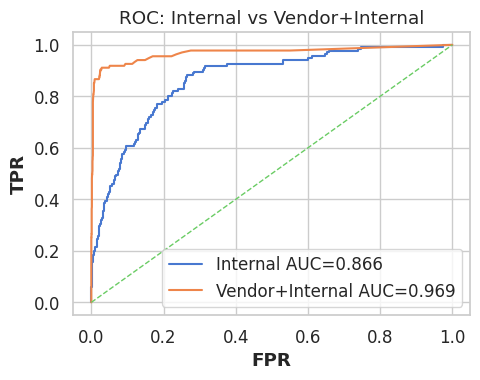

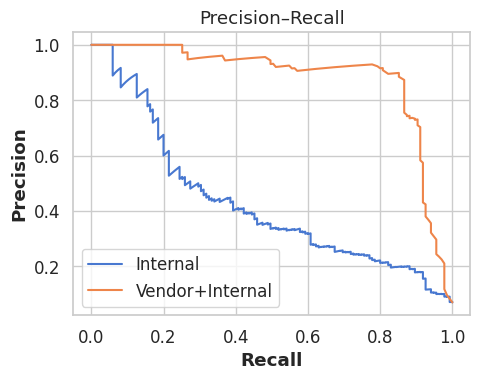

In [36]:
# -----------------------------
# 7) A quick ROC/PR visual (optional)(add confusion matrix)
# -----------------------------
import matplotlib.pyplot as plt

fpr_i, tpr_i, _ = roc_curve(y_te, p_int)
fpr_v, tpr_v, _ = roc_curve(y_te, p_vnd)
pr_i, rc_i, _   = precision_recall_curve(y_te, p_int)
pr_v, rc_v, _   = precision_recall_curve(y_te, p_vnd)

plt.figure(figsize=(5,4))
plt.plot(fpr_i, tpr_i, label=f'Internal AUC={auc_int:.3f}')
plt.plot(fpr_v, tpr_v, label=f'Vendor+Internal AUC={auc_vnd:.3f}')
plt.plot([0,1],[0,1],'--', lw=1)
plt.title('ROC: Internal vs Vendor+Internal')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(rc_i, pr_i, label='Internal')
plt.plot(rc_v, pr_v, label='Vendor+Internal')
plt.title('Precision–Recall')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.tight_layout(); plt.show()

80:20